L'analyse des données
Le but de ce cahier est de prédire la mort à l'hôpital en visite à l'USI sur la base des 24 premières heures de séjour à l'unité de soins intensifs.

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
import seaborn as sns
import urllib.request
import zipfile
import os
from time import time

# custom py files
import dtw
import KNN
import visuals as vs

# for pretty printing pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('seaborn-notebook')

Télécharger les données¶

In [3]:
# generate a data folder, we store all data in this folder
if not os.path.exists('data'):
    os.makedirs('data')
    
# download and unzip the rawdata
url = 'https://api.onedrive.com/v1.0/shares/u!aHR0cHM6Ly8xZHJ2Lm1zL3UvcyFBdk96S3k0djAydHpndFU0OGphUW9DMU5QR1VOTGc/root/content'
urllib.request.urlretrieve(url, "download.zip")

with zipfile.ZipFile("download.zip","r") as zip_ref:
    zip_ref.extractall("data")

Les fonctions

In [4]:
def get_path(filename, suffix):
    """
    Return the path of the file.
    
    iuputs:
      - filename: string that points the file
      - suffic: string that indicates the file format
    """
    cwd = os.getcwd()
    dir_name = os.path.join(cwd, 'data')
    return os.path.join(dir_name, filename + "." + suffix)

In [6]:
names = ['X_train', 'X_test', 'y_train', 'y_test']

data = {(name):(pd.read_csv(get_path(name, 'csv'), index_col = [0,1]) if name.split('_')[0] == 'X' 
                else pd.read_csv(get_path(name, 'csv'), index_col = 0)) for name in names }


Données DTW
Ensuite, nous générons les données pour le classificateur kNN de distorsion temporelle dynamique (DTW).

In [10]:
# data for DTW kNN classifier
data_dtw = {}

for X in ['X_test', 'X_train']:
    df = data[X]
    data_dtw[X] = []
    for key, value in df.groupby(level=0):
        data_dtw[X].append(value.values)
    data_dtw[X] = np.array(data_dtw[X])

In [11]:
# données pour les classificateurs conventionnels
data_agg = {}

# extraire les propriétés statistiques telles que moyenne, médiane, max, min, std pour chaque patient utilisant groupby dans Pandas
for name, df in data.items():
    data_agg[name] = df.groupby('id').agg([np.median, max, min, np.mean, np.std])
    data_agg[name].columns = ['_'.join( ( col[0], col[1])) for col in data_agg[name].columns]

In [12]:
# Fonction pour compter les points de données au-dessous / au-dessus du seuil
def count_below_threshold(array, threshold):
    '''Compter les points de données inférieurs au seuil dans la série chronologique'''
    return np.sum(array < threshold.reshape(1,array.shape[1]), axis=0)/array.shape[0]

def count_above_threshold(array, threshold):
    '''Compter les points de données au-dessus du seuil dans la série chronologique'''
    return np.sum(array > threshold.reshape(1,array.shape[1]), axis=0)/array.shape[0]

data_quartiles = {}

# constantes
count_funcs = [count_below_threshold, count_above_threshold]
column_names = ['below_Q1', 'above_Q3']
quartiles = {key: data["X_train"].quantile(value) \
             for (key,value) in zip(['Q1', 'Q3'], [0.25, 0.75])} # global quantiles of trainig data

# Boucle pour créer de nouvelles fonctionnalités et les stocker dans des quartiles de données
for name, df in data.items():
    if name.split('_')[0] == 'X': # Only consider the training data
        data_quartiles[name] = {}
        for Q, func, column in zip(['Q1', 'Q3'], count_funcs, column_names):
            data_quartiles[name][Q] = df.groupby('id').apply(lambda x: func(x, quartiles[Q].values))
            data_quartiles[name][Q].columns = ['_'.join( ( col, column)) for col in data_quartiles[name][Q].columns]
            
# Concat data_quantile into data_agg
for name in ['X_train', 'X_test']:
    combined_df = pd.concat( [data_quartiles[name]['Q1'], data_quartiles[name]['Q3'], data_agg[name]], axis =1)
    data_agg[name] = combined_df

Calcul des scores de Benchmark

In [13]:
from sklearn.metrics import f1_score, matthews_corrcoef

# stocker les partitions dans un dictionnaire
score_metrics = {'f1': f1_score, 'mcc': matthews_corrcoef}

# crée le score pour Benchmark
score_benchmark = {}

# performance de Benchmark
for name, func in score_metrics.items():
    score_benchmark[name+'_test'] = func(data['y_test']['in_hospital_death'], data['y_test']['sapsii_prediction'])
    score_benchmark[name+'_train'] = func(data['y_train']['in_hospital_death'], data['y_train']['sapsii_prediction'])

print("Le score F1 et le MCC du benchmark des données de test sont: {}, {}".format(score_benchmark['f1_test'], 
                                                                                 score_benchmark['mcc_test']))

# performance de naive learner
score_naive = {}
# sur le sous-ensemble d'échantillons de test
score_naive['f1_test'] = f1_score(data['y_test']['in_hospital_death'][:480], np.ones( (480,) ))
score_naive['mcc_test'] = matthews_corrcoef(data['y_test']['in_hospital_death'][:480], np.ones( (480,) ))

print("Le score F1 et le MCC du prédicteur naïf sont: {}, {}".format(score_naive['f1_test'], score_naive['mcc_test']))

Le score F1 et le MCC du benchmark des données de test sont: 0.3713768115942029, 0.28981016250795055
Le score F1 et le MCC du prédicteur naïf sont: 0.2189239332096475, 0.0


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Prédiction avec le classificateur DTN kNN
Ici, c'est la première tentative de former l'apprenant en DTW avec un classificateur KNN.

In [14]:
results = {}

# Custom metric
def dtw_metric(a,b):
    similarity, _ = dtw.dynamic_time_wraping(a,b, distance.euclidean)
    return similarity

# initize the classifier
dtw_kNN_clf = KNN.KNNClassifier(metric=dtw_metric)

# First, we start with 1922 training samples since kNN is a slow classifier
start = time() # Get start time
dtw_kNN_clf.fit(data_dtw['X_train'][:1922], data['y_train']['in_hospital_death'][:1922])
end = time() # Get end time
    
# Record the training time
results['train_time'] = end - start
    
# Make predictions on train subset (with the size of test set) and test set
start = time() # Get start time
predictions_test = dtw_kNN_clf.predict(data_dtw['X_test'][:480])
end = time() # Get end time
results['pred_time'] = end - start
            
# Compute F-score on the train subset and test set
for name, func in score_metrics.items():
    results[name+'_test'] = func(data['y_test']['in_hospital_death'][:480], predictions_test)
        
# Return the results
results

{'f1_test': 0.27499999999999997,
 'mcc_test': 0.2611594868357666,
 'pred_time': 2432.8259539604187,
 'train_time': 0.0040738582611083984}

In [15]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test, metrics): 
    '''
    contributions:
        - learner: l'algorithme d'apprentissage à former et à prédire sur
        - sample_size: la taille des échantillons (nombre) à tirer de l'ensemble d'apprentissage
        - X_train: ensemble d'exercices de fonctionnalités
        - y_train: ensemble de formation au revenu
        - X_test: ensemble de tests de fonctionnalités
        - y_test: ensemble de tests de revenu
        - metrics: dictionnaire pour stocker les métriques
     '''
    results = {}
    
    # Ajuster l'apprenant aux données d'apprentissage en les coupant avec 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Enregistrer le temps de formation
    results['train_time'] = end - start
    
    # Faire des prédictions sur les données de train
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    results['pred_time'] = end - start
    
    for score, func in metrics.items():
    # Calculer le score sur le sous-ensemble du train et l'ensemble de test
        results[score+"_train"] = func(y_train, predictions_train)
        results[score+"_test"] = func(y_test, predictions_test)
    
    # Succès
    print("{} formé sur {} échantillons.".format(learner.__class__.__name__, sample_size))
        
# Retourner les résultats
    return results

LogisticRegression formé sur 192 échantillons.
LogisticRegression formé sur 1922 échantillons.
LogisticRegression formé sur 19220 échantillons.
DecisionTreeClassifier formé sur 192 échantillons.
DecisionTreeClassifier formé sur 1922 échantillons.
DecisionTreeClassifier formé sur 19220 échantillons.
GradientBoostingClassifier formé sur 192 échantillons.
GradientBoostingClassifier formé sur 1922 échantillons.
GradientBoostingClassifier formé sur 19220 échantillons.


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


KerasClassifier formé sur 192 échantillons.
KerasClassifier formé sur 1922 échantillons.
KerasClassifier formé sur 19220 échantillons.


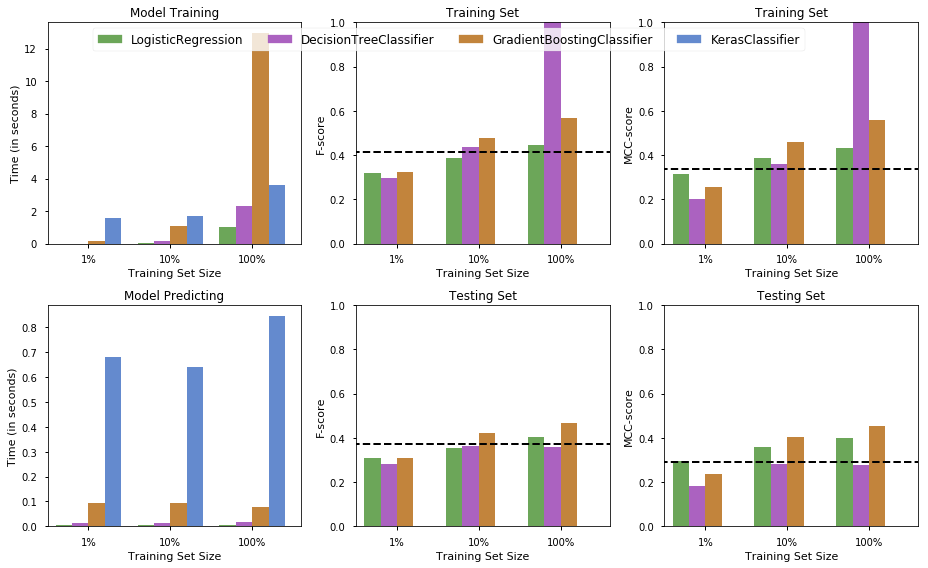

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.wrappers.scikit_learn import KerasClassifier

# fixe la graine aléatoire pour la reproductibilité
seed = 0
np.random.seed(seed)

# créer un wrapper keras
def keras_model():
    # créer un modèle
    clf_MLP = Sequential()
    clf_MLP.add(Dense(128, activation='relu', input_shape= data_agg['X_train'].shape[1:]))
    clf_MLP.add(Dropout(0.1))
    clf_MLP.add(Dense(32, activation='relu'))
    clf_MLP.add(Dropout(0.1))
    clf_MLP.add(Dense(8, activation='relu'))
    clf_MLP.add(Dropout(0.1))
    clf_MLP.add(Dense(1, activation='sigmoid'))
    #clf_MLP.summary()
    clf_MLP.compile(optimizer= 'adam', loss='binary_crossentropy')
    return clf_MLP

# Initialiser les trois modèles avec les paramètres par défaut
clf_A = LogisticRegression(random_state = 0) 
clf_B = DecisionTreeClassifier(random_state = 0)
clf_C = GradientBoostingClassifier(random_state=0)
clf_MLP = KerasClassifier(build_fn=keras_model, verbose=0)

# Calculez le nombre d'échantillons pour 1%, 10% et 100% des données d'entraînement
samples_100 = len(data['y_train'])
samples_10 = int(round(0.1*samples_100))
samples_1 = int(round(0.1*samples_10))

# Collecter les résultats sur les apprenants
results = {}
for clf in [clf_A, clf_B, clf_C, clf_MLP]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, 
                      data_agg['X_train'].values, data['y_train']['in_hospital_death'], 
                      data_agg['X_test'].values, data['y_test']['in_hospital_death'], score_metrics)
        
# visualiser les résultats
vs.evaluate(results, score_benchmark)

In [35]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def gridsearch(clf, scorer, X_train, y_train, X_test, y_test, parameters):
    """ apply grid search on clf """
# Effectuez une recherche de grille sur le classificateur en utilisant 'scorer' comme méthode de notation en utilisant GridSearchCV ()    grid_obj = GridSearchCV(estimator=clf, scoring=scorer, param_grid=parameters, cv=5)

# Ajoute l'objet de recherche de grille aux données d'apprentissage et trouve les paramètres optimaux en utilisant fit ()    grid_fit = grid_obj.fit(X_train, y_train)

# Obtenez le meilleur estimateur, paramètres et cv_results    best_clf = grid_fit.best_estimator_
    best_score = grid_fit.best_score_
    best_params = grid_fit.best_params_
    
    cv_results = grid_fit.cv_results_
    means = cv_results['mean_test_score']
    stds = cv_results['std_test_score']
    params = cv_results['params']
    
    print("Best parameters: {}".format(best_params))
    print("Best score: {}".format(best_score))
    for mean, stdev, param in zip(means, stds, params):
        print("mean: {:3f}, std: {:3f} for {}".format(mean, stdev, param))
    
    return best_score, best_params, cv_results

Réglage sur le classificateur boost boost.

In [34]:
# initialiser le classificateur
clf = GradientBoostingClassifier(random_state = 0)

# Créer un objet de scoring fbeta_score en utilisant make_scorer ()
scorer = make_scorer(f1_score)

# Créez la liste des paramètres que vous souhaitez régler, en utilisant un dictionnaire si nécessaire.
# nous accordons d'abord le taux d'apprentissage du classificateur
learning_rate = np.arange(0.1, 0.31, 0.1)
n_estimators = np.arange(60,101,20)
parameters = dict(learning_rate=learning_rate, n_estimators=n_estimators)

best_clf, best_predictions, cv_results = gridsearch(clf, scorer, 
                                                    data_agg['X_train'], data['y_train']['in_hospital_death'], 
                                                    data_agg['X_test'], data['y_test']['in_hospital_death'], 
                                                    parameters)

NameError: name 'grid_fit' is not defined

In [25]:
# learning rate = 0.2 in this case
clf = GradientBoostingClassifier(random_state = 0)

learning_rate = [0.2]
n_estimators = [100]
max_depth = np.arange(3, 12, 2)
min_samples_split = np.arange(100, 1001, 200)

parameters = dict(learning_rate=learning_rate, n_estimators=n_estimators, 
                  max_depth=max_depth, min_samples_split=min_samples_split)

best_clf, best_predictions, cv_results = gridsearch(clf, scorer, 
                                        data_agg['X_train'], data['y_train']['in_hospital_death'], 
                                        data_agg['X_test'], data['y_test']['in_hospital_death'], 
                                        parameters)

NameError: name 'grid_fit' is not defined

In [29]:
# learning rate = 0.25 in this case
clf = GradientBoostingClassifier(random_state = 0)

learning_rate = [0.2]
n_estimators = [100]
max_depth = [5]
min_samples_split = [100]
min_samples_leaf = np.arange(1, 81, 20)

parameters = dict(learning_rate=learning_rate, n_estimators=n_estimators, 
                  max_depth=max_depth, min_samples_split=min_samples_split,
                  min_samples_leaf=min_samples_leaf)

best_clf, best_predictions, cv_results = gridsearch(clf, scorer, 
                                        data_agg['X_train'], data['y_train']['in_hospital_death'], 
                                        data_agg['X_test'], data['y_test']['in_hospital_death'], 
                                        parameters)

Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 100, 'n_estimators': 100}
Best score: 0.506621848726305
mean: 0.506622, std: 0.010116 for {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 100, 'n_estimators': 100}
mean: 0.501289, std: 0.021659 for {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 21, 'min_samples_split': 100, 'n_estimators': 100}
mean: 0.493081, std: 0.010773 for {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 41, 'min_samples_split': 100, 'n_estimators': 100}
mean: 0.493425, std: 0.021709 for {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 61, 'min_samples_split': 100, 'n_estimators': 100}


In [30]:
tuned_GB_clf = GradientBoostingClassifier(random_state = 0, learning_rate=0.2, n_estimators=100, 
                                          max_depth=5, min_samples_split=100, min_samples_leaf=1)

tuned_GB_clf.fit(data_agg['X_train'].values, data['y_train']['in_hospital_death'])

predictions_test = tuned_GB_clf.predict(data_agg['X_test'].values)
    
tuned_GB_clf_results = {}
for score, func in score_metrics.items():
# Compute score on the train subset and test set
    tuned_GB_clf_results[score+"_test"] = func(data['y_test']['in_hospital_death'], predictions_test)
    
print('tuned gradient boost:', tuned_GB_clf_results)

tuned gradient boost: {'f1_test': 0.48437500000000006, 'mcc_test': 0.4485994263811551}


In [31]:
# fix random seed for reproducibility
seed = 0
np.random.seed(seed)

# create keras wrapper
def keras_model():
    clf_MLP = Sequential()
    clf_MLP.add(Dense(128, activation='relu', input_shape= data_agg['X_train'].shape[1:]))
    clf_MLP.add(Dropout(0.1))
    clf_MLP.add(Dense(32, activation='relu'))
    clf_MLP.add(Dropout(0.1))
    clf_MLP.add(Dense(8, activation='relu'))
    clf_MLP.add(Dropout(0.1))
    clf_MLP.add(Dense(1, activation='sigmoid'))
    clf_MLP.compile(optimizer= 'adam', loss='binary_crossentropy')
    return clf_MLP

clf = KerasClassifier(build_fn=keras_model, verbose=0)

# Make an f1_score scoring object using make_scorer()
scorer = make_scorer(f1_score)

# define the grid search parameters
batch_size = [32, 256, 512]
epochs = [10, 50, 100]
parameters = dict(batch_size=batch_size, epochs=epochs)

best_clf, best_predictions, cv_results = gridsearch(clf, scorer, 
                                        data_agg['X_train'].values, data['y_train']['in_hospital_death'], 
                                        data_agg['X_test'].values, data['y_test']['in_hospital_death'], 
                                        parameters)

Best parameters: {'batch_size': 32, 'epochs': 10}
Best score: 0.49446741356509083
mean: 0.494467, std: 0.034073 for {'batch_size': 32, 'epochs': 10}
mean: 0.471002, std: 0.015658 for {'batch_size': 32, 'epochs': 50}
mean: 0.456275, std: 0.018518 for {'batch_size': 32, 'epochs': 100}
mean: 0.481420, std: 0.019687 for {'batch_size': 256, 'epochs': 10}
mean: 0.491392, std: 0.032887 for {'batch_size': 256, 'epochs': 50}
mean: 0.481981, std: 0.018899 for {'batch_size': 256, 'epochs': 100}
mean: 0.448962, std: 0.013769 for {'batch_size': 512, 'epochs': 10}
mean: 0.492628, std: 0.022415 for {'batch_size': 512, 'epochs': 50}
mean: 0.465478, std: 0.015190 for {'batch_size': 512, 'epochs': 100}


In [32]:
# fix random seed for reproducibility
seed = 0
np.random.seed(seed)

# create model
tuned_MLP_clf = Sequential()
tuned_MLP_clf.add(Dense(128, activation='relu', input_shape= data_agg['X_train'].shape[1:]))
tuned_MLP_clf.add(Dropout(0.1))
tuned_MLP_clf.add(Dense(32, activation='relu'))
tuned_MLP_clf.add(Dropout(0.1))
tuned_MLP_clf.add(Dense(8, activation='relu'))
tuned_MLP_clf.add(Dropout(0.1))
tuned_MLP_clf.add(Dense(1, activation='sigmoid'))
tuned_MLP_clf.compile(optimizer='adam', loss='binary_crossentropy')

# train the model
if not os.path.exists('data'):
    os.makedirs('data')
tuned_MLP_clf.fit(data_agg['X_train'].values, data['y_train']['in_hospital_death'],
                  batch_size=512, epochs=50, verbose=1, shuffle=True)

# predict the labels
predictions_test = tuned_MLP_clf.predict(data_agg['X_test'].values) > 0.5

# record the results
tuned_MLP_clf_results = {}
for score, func in score_metrics.items():
    tuned_MLP_clf_results[score+"_test"] = func(data['y_test']['in_hospital_death'], predictions_test)
    
print('tuned MLP:', tuned_MLP_clf_results)


Epoch 1/50
19220/19220 [==============================] - 3s 163us/step - loss: 0.3992
Epoch 2/50
19220/19220 [==============================] - 0s 14us/step - loss: 0.2966
Epoch 3/50
19220/19220 [==============================] - 0s 14us/step - loss: 0.2734
Epoch 4/50
19220/19220 [==============================] - 0s 14us/step - loss: 0.2662
Epoch 5/50
19220/19220 [==============================] - 0s 14us/step - loss: 0.2630
Epoch 6/50
19220/19220 [==============================] - 0s 14us/step - loss: 0.2588
Epoch 7/50
19220/19220 [==============================] - 0s 14us/step - loss: 0.2564
Epoch 8/50
19220/19220 [==============================] - 0s 14us/step - loss: 0.2555
Epoch 9/50
19220/19220 [==============================] - 0s 14us/step - loss: 0.2540
Epoch 10/50
19220/19220 [==============================] - 0s 13us/step - loss: 0.2504
Epoch 11/50
19220/19220 [==============================] - 0s 14us/step - loss: 0.2501
Epoch 12/50
19220/19220 [==========================

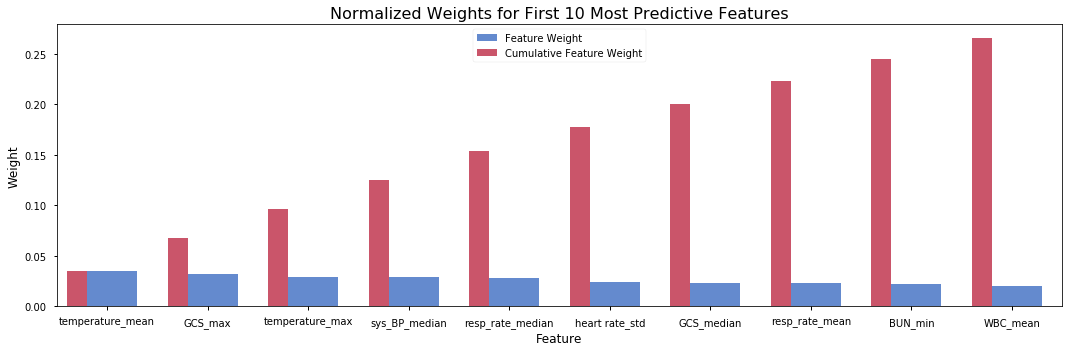

In [33]:
# Train the supervised model on the training set using .fit(X_train, y_train)
model = GradientBoostingClassifier(random_state = 0, learning_rate=0.2, n_estimators=100, 
                                   max_depth=5, min_samples_split=100, min_samples_leaf=1)

model.fit(data_agg['X_train'], data['y_train']['in_hospital_death'])

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, data_agg['X_train'], data['y_train']['in_hospital_death'])